# DCMtoCocoUtility


## Notes
- added all available classes from "Study" level data.  (060321)  
Issues: Lots of Image level records do not have bounding boxes, even though they are positive...need to explore  
Issue: Duplicate records (seems to be a known issue on kaggle)

In [1]:
import os
import ast
import numpy as np
import pandas as pd
from pathlib import Path
import datetime
import glob
import json

from PIL import Image
from tqdm.auto import tqdm
import pydicom
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

from fastai.medical.imaging import *

In [2]:
params = dict(
    size=512,
    size_trans=512,
    batch_size=8,
    ds_size=500
    )

# Laptop Workstation
# path_dicom = Path('/host_Data/DataSets/Kaggle-SIIM Covid 19/siim-covid19-detection')

# AZ Server
path_dicom = Path('/workspace/WSI/SIIM-Covid19-Detection')

path_output_patches = path_dicom / ('DS-COCO_' + str(params['size']))
labels_dcm_image = 'train_image_level.csv'
labels_dcm_study = 'train_study_level.csv'

<span style="color: #0087e4; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Read Dicom Images and  Resize and Save to PNG</span>

In [3]:
from pydicom.pixel_data_handlers.util import apply_voi_lut

def read_xray(dicom, voi_lut = True, fix_monochrome = True):
    # Original from: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    # dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to 
    # "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)    
    
    return data

In [4]:
def resize(array, size, keep_ratio=False, resample=Image.LANCZOS):
    # Original from: https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image
    im = Image.fromarray(array)
    
    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
    
    return im

## Create Resized PNG Images (Only Run Once)

In [5]:
new_size = params['size']

for split in ['train', 'test']:
# for split in ['test']:
    save_dir = path_output_patches / f'{split}/'
    os.makedirs(save_dir, exist_ok=True)

    image_ids = []
    folder_ids = []
    study_ids = []
    widths = []
    heights = []

    dicoms = get_dicom_files(path_dicom / split)

    print('Count of Dicom Files=', len(dicoms))

    for item in tqdm(dicoms):
        path = str(item)
        dicom = item.dcmread()
        
        # set keep_ratio=True to have original aspect ratio
        xray = read_xray(dicom)
        im = resize(xray, size=new_size)
        
        path_split = path.split('/')
        study_id = path_split[-3]
        folder_id = path_split[-2]
        image_name = path_split[-1].replace('.dcm', '_image')
        
        im.save(os.path.join(save_dir, image_name+'.png'))
        
        image_ids.append(image_name)
        folder_ids.append(folder_id)
        study_ids.append(study_id)
        widths.append(xray.shape[0])
        heights.append(xray.shape[1])
    
    df = pd.DataFrame.from_dict({'id': image_ids, 'folder_id': folder_ids,
                                 'study_id': study_ids, 'width': widths,
                                 'height': heights})
    df.to_csv(path_output_patches / f'{split}_meta.csv', index=False)

<span style="color: #0087e4; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Process and Resize Bounding Boxes</span>

### Load Study & Image Level Train CSV's

In [6]:
df_train_image = pd.read_csv(path_dicom / "train_image_level.csv")
df_train_image.head(3)

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7


In [7]:
df_train_study = pd.read_csv(path_dicom / "train_study_level.csv")
df_train_study['StudyInstanceUID'] = df_train_study['id'].apply(lambda x: x.replace('_study', ''))
del df_train_study['id']
df_train_study.head(3)

,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,StudyInstanceUID
0,0,1,0,0,00086460a852
1,0,0,0,1,000c9c05fd14
2,1,0,0,0,00292f8c37bd


In [8]:
df_image_study = df_train_image.merge(df_train_study, on='StudyInstanceUID')

### Load Train_meta CSV

In [9]:
df_train_meta = pd.read_csv(path_output_patches / "train_meta.csv")
df_train_meta.head(3)

,id,folder_id,study_id,width,height
0,37c3ad608cb3_image,7cc418f2e1b8,c925ca312688,2991,2992
1,62fb74aea804_image,64db7471fca8,e8ca5a4146ab,3488,4256
2,1335b56b7a98_image,c1773779a1d8,37ffdf650199,2874,2840


In [10]:
#Merge Train_Meta with Train_Image
df_train = df_train_image.merge(df_train_meta, on='id')
df_train.head(3)

,id,boxes,label,StudyInstanceUID,folder_id,study_id,width,height
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,81456c9c5423,5776db0cec75,3488,4256
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,d8a644cc4f93,ff0879eb20ed,2320,2832
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,22897cd1daa0,9d514ce429a7,2544,3056


In [11]:
#Merge Train_Study into Train_Image & Train_Meta
df_image_study_meta = df_train.merge(df_train_study, on='StudyInstanceUID')
df_image_study_meta.head(3)

,id,boxes,label,StudyInstanceUID,folder_id,study_id,width,height,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,81456c9c5423,5776db0cec75,3488,4256,0,1,0,0
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,d8a644cc4f93,ff0879eb20ed,2320,2832,1,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,22897cd1daa0,9d514ce429a7,2544,3056,0,1,0,0


In [12]:
# add StudyInstanceUID_count column
group_col = 'StudyInstanceUID'
df=pd.DataFrame(df_image_study_meta.groupby(group_col)['id'].count())
df.columns = [f'{group_col}_count']
df_image_study_meta=df_image_study_meta.merge(df.reset_index(), on=group_col)

one_study_multi_image_df = df_image_study_meta[df_image_study_meta[f'{group_col}_count'] > 1]
print(len(one_study_multi_image_df))
df_image_study_meta = df_image_study_meta[df_image_study_meta[f'{group_col}_count'] == 1] # delete 'StudyInstanceUID_count > 1' data
one_study_multi_image_df.head(3)

512


,id,boxes,label,StudyInstanceUID,folder_id,study_id,width,height,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,StudyInstanceUID_count
22,00c1515729a8_image,NaN,none 1 0 0 1 1,1a58b43cf286,461096d084ba,1a58b43cf286,2539,3050,0,1,0,0,2
23,cada5310214b_image,"[{'x': 981.75034, 'y': 256.08181, 'width': 225.79065, 'height': 509.18106}, {'x': 323.96213, 'y': 201.93814, 'width': 240.76663, 'height': 480.38121}]",opacity 1 981.75034 256.08181 1207.54099 765.26287 opacity 1 323.96213 201.93814 564.72876 682.31935,1a58b43cf286,0704ff4c28b5,1a58b43cf286,1140,1387,0,1,0,0,2
25,00e3a7e91a34_image,NaN,none 1 0 0 1 1,74ba8f2badcb,c8755f476425,74ba8f2badcb,1760,2140,1,0,0,0,4


### Create record for Each Bounding Box

In [19]:
#Fill NaN VAlues in DF
df_image_study_meta = df_image_study_meta.fillna(0)

In [21]:
class_names = ['Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']
classdata2num = {
    '[0, 0, 0]': 1,
    '[1, 0, 0]': 2,
    '[0, 1, 0]': 3,
    '[0, 0, 1]': 4
}
# num2label = {0: 'Negative', 1: 'Typical Appearance', 2: 'Indeterminate Appearance', 3: 'Atypical Appearance'}
num2label = {1: 'Negative', 2: 'Typical', 3: 'Indeterminate', 4: 'Atypical'}
classmap = num2label

In [23]:
new_size = (params['size'], params['size'])
df_idx=0

for idx, row in tqdm(df_image_study_meta.iterrows(), total=df_image_study_meta.shape[0]):
    img = cv2.imread(os.path.join("train", row.id.replace("_image", ".png")))

    if row.boxes != 0:
        bboxes = [list(bbox.values()) for bbox in ast.literal_eval(row.boxes)]
    else:
        bboxes = [[0,0,1,1]]
        
    height_ratio, width_ratio = (new_size[0]/row.height, new_size[1]/row.width)
    
    for box in bboxes:
        box[2] = box[2]+box[0]
        box[3] = box[3]+box[1]
        box = (box[0]*height_ratio, box[1]*width_ratio,
               box[2]*height_ratio, box[3]*width_ratio)
        
        classdata = row[class_names].values
        classid = classdata2num[str(classdata.tolist())]
        classlabel = num2label[classid]
  
        
        row_df = pd.DataFrame({'id':row.id,
                       'StudyInstanceUID':row.StudyInstanceUID,
                       'folder_id':row.folder_id,
                       'study_id':row.study_id,
                       'width':row.width,
                       'height':row.height,
                       'xmin':round(box[0]),
                       'ymin':round(box[1]),
                       'xmax':round(box[2]),
                       'ymax':round(box[3]),
                       'class_id':classid,
                       'class_label':classlabel,
                       'Negative for Pneumonia': row['Negative for Pneumonia'],
                       'Typical Appearance':row['Typical Appearance'],
                       'Indeterminate Appearance':row['Indeterminate Appearance'],
                       'Atypical Appearance':row['Atypical Appearance']}, index=[df_idx])
        if df_idx==0:
            df_train_processed = row_df
        else:
            df_train_processed = pd.concat([df_train_processed, row_df])

        df_idx+=1
        
df_train_processed.head(3)

  0%|          | 0/5822 [00:00<?, ?it/s]

,id,StudyInstanceUID,folder_id,study_id,width,height,xmin,ymin,xmax,ymax,class_id,class_label,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2_image,5776db0cec75,81456c9c5423,5776db0cec75,3488,4256,95,85,218,367,2,Typical,0,1,0,0
1,000a312787f2_image,5776db0cec75,81456c9c5423,5776db0cec75,3488,4256,270,87,402,345,2,Typical,0,1,0,0
2,000c3a3f293f_image,ff0879eb20ed,d8a644cc4f93,ff0879eb20ed,2320,2832,0,0,0,0,1,Negative,1,0,0,0
3,0012ff7358bc_image,9d514ce429a7,22897cd1daa0,9d514ce429a7,2544,3056,113,40,259,241,2,Typical,0,1,0,0
4,0012ff7358bc_image,9d514ce429a7,22897cd1daa0,9d514ce429a7,2544,3056,300,81,404,323,2,Typical,0,1,0,0


In [24]:
df_train_processed.to_csv(path_output_patches / "df_train_processed_meta.csv", index=False)
df_train_processed.shape

(9225, 16)

### Check Accuracy of BBoxes & Labels

In [25]:
# df_train_image.loc[(df_train_image['StudyInstanceUID'] == 'f4ead5d70ba6')]

In [26]:
# df_image_study_meta.loc[(df_image_study_meta['StudyInstanceUID'] == '9d514ce429a7')]

In [44]:
df_train_processed.loc[(df_train_processed['id'] == '79f32a83d80f_image')]

,id,StudyInstanceUID,folder_id,study_id,width,height,xmin,ymin,xmax,ymax,class_id,class_label,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,target
4386,79f32a83d80f_image,19195bf306ef,bbfd19136f3f,19195bf306ef,3052,3052,137,179,168,203,2,Typical,0,1,0,0,Typical Appearance
4387,79f32a83d80f_image,19195bf306ef,bbfd19136f3f,19195bf306ef,3052,3052,316,225,407,294,2,Typical,0,1,0,0,Typical Appearance
4388,79f32a83d80f_image,19195bf306ef,bbfd19136f3f,19195bf306ef,3052,3052,154,239,213,285,2,Typical,0,1,0,0,Typical Appearance


In [30]:
# df_train_processed.loc[(df_train_processed['xmin'] == 0) & (df_train_processed['class_id'] != 0)]

In [31]:
# df_train_processed.loc[(df_train_processed['class_id'] == 3)]

## Analyze Processed Data

In [32]:
from bokeh.plotting import figure as bokeh_figure
from bokeh.io import output_notebook, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.models.widgets import Tabs
import pandas as pd
from PIL import Image
from sklearn import preprocessing
import random
from random import randint

In [33]:

def pie_plot(train_df, variable):
    """
        input: variable ex: "Sex"
        output: bar plot & value count
    """
    # get feature
    var = train_df[variable]
    # count number of categorical variable(value/sample)
    varValue = var.value_counts()
    
    # visualize
    plt.figure(figsize = (20,10))
    plt.pie(varValue, labels=varValue.index, autopct="%1.1f%%")
#     plt.xticks(varValue.index, varValue.index.values)
#     plt.ylabel("Frequency")
    plt.title('target')
    plt.show()

Typical Appearance          2725
Negative for Pneumonia      1623
Indeterminate Appearance    1007
Atypical Appearance          467
Name: target, dtype: int64


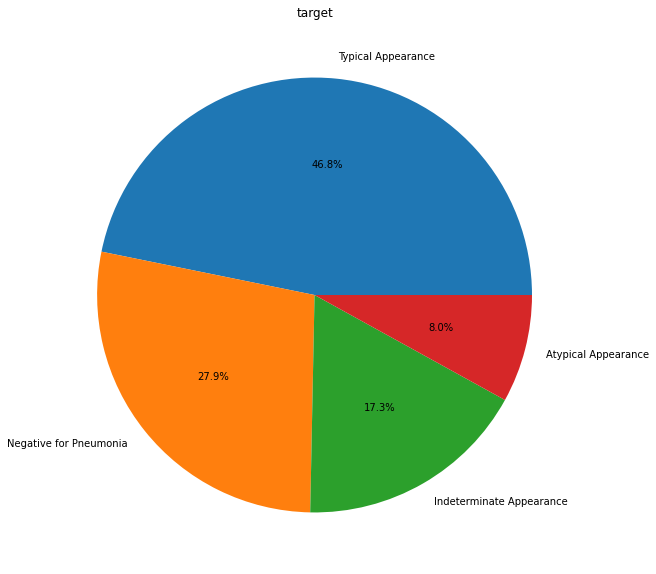

In [34]:
train = df_image_study_meta
    
train['target'] = 'Negative for Pneumonia'
train.loc[train['Typical Appearance']==1, 'target'] = 'Typical Appearance'
train.loc[train['Indeterminate Appearance']==1, 'target'] = 'Indeterminate Appearance'
train.loc[train['Atypical Appearance']==1, 'target'] = 'Atypical Appearance'
print(train.target.value_counts())
pie_plot(train, 'target')   

Typical Appearance          5616
Negative for Pneumonia      1623
Indeterminate Appearance    1375
Atypical Appearance          611
Name: target, dtype: int64


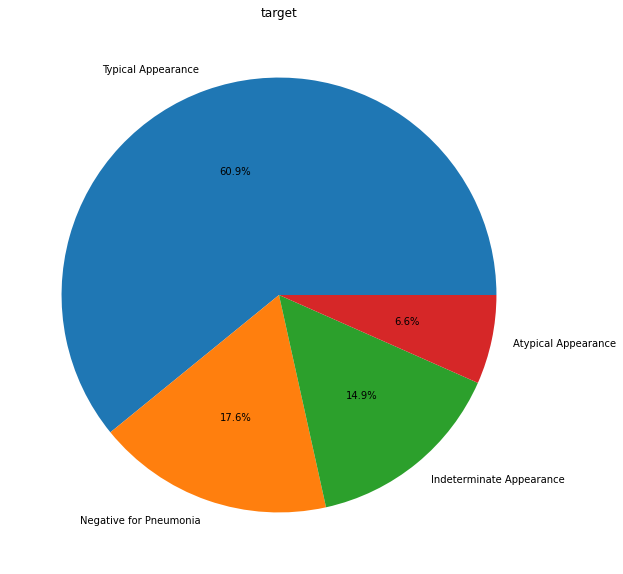

In [35]:
train = df_train_processed
    
train['target'] = 'Negative for Pneumonia'
train.loc[train['Typical Appearance']==1, 'target'] = 'Typical Appearance'
train.loc[train['Indeterminate Appearance']==1, 'target'] = 'Indeterminate Appearance'
train.loc[train['Atypical Appearance']==1, 'target'] = 'Atypical Appearance'
print(train.target.value_counts())
pie_plot(train, 'target')   

## Load Annotations from Dataset


In [36]:
df_annotations = pd.read_csv(path_output_patches / "df_train_processed_meta.csv")
print('Annotation Count=', len(df_annotations))
# df_annotations.sample(100)

Annotation Count= 9225


In [38]:
#Load Unique Image ID's and Remove Images with No BBoxes
print('Cnt of df_annotations=', len(df_annotations))
df_BBoxes_True = df_annotations.loc[df_annotations['xmin'] != 0]
print('Cnt of df_BBoxes_True=', len(df_BBoxes_True))
train_img_ids = df_BBoxes_True.id.unique()

print(f"Train image count: {len(train_img_ids)}")

Cnt of df_annotations= 9225
Cnt of df_BBoxes_True= 7504
Train image count: 4115


## Generate COCO Dataset


In [39]:
now = datetime.datetime.now()

data = dict(
    info=dict(
        description='SIIM Covid-19 GroupKfold',
        url=None,
        version=None,
        year=now.year,
        contributor=None,
        date_created=now.strftime('%Y-%m-%d %H:%M:%S.%f'),
    ),
    licenses=[dict(
        url=None,
        id=0,
        name=None,
    )],
    images=[
        # license, url, file_name, height, width, date_captured, id
    ],
    type='instances',
    annotations=[
        # segmentation, area, iscrowd, image_id, bbox, category_id, id
    ],
    categories=[
        # supercategory, id, name
    ],
)

In [40]:
#Generate Categories section of COCO
for key, value in classmap.items():
    data['categories'].append(dict(
        supercategory=None,
        id=key,
        name=value,
    ))
    
# data

In [41]:
H, W = (params['size'], params['size'])

## Setting the output annotation json file paths
train_out_file = 'coco_train_annotations_' + str(params['size']) + 'px.json'


In [42]:
#Generate images and annotations sections of COCO
data_train = data.copy()
data_train['images'] = []
data_train['annotations'] = []

for i, img_id in tqdm(enumerate(train_img_ids), total=len(train_img_ids)):

    data_train['images'].append(dict(license=0,
                                     url=None,
                                     file_name=img_id+'.png',
                                     height=H,
                                     width=W,
                                     date_captured=None,
                                     id=i
                                    ))

    img_annotations = df_annotations[df_annotations.id==img_id]

    for idx, row in img_annotations.iterrows():
        x_min, y_min, x_max, y_max = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
        area = round((x_max-x_min)*(y_max-y_min),1)
        bbox =[
                int(x_min),
                int(y_min),
                int(x_max-x_min),
                int(y_max-y_min)
                ]

        data_train['annotations'].append(dict(id=len(data_train['annotations']),
                                              image_id=i,
                                              category_id=int(row['class_id']),
                                              area=int(area),
                                              bbox=bbox,
                                              iscrowd=0)) 

  0%|          | 0/4115 [00:00<?, ?it/s]

In [43]:
with open(path_output_patches / train_out_file, 'w') as f:
    json.dump(data_train, f, indent=4)

<p style='text-align: center;'><span style="color: #000508; font-family: Segoe UI; font-size: 1.4em; font-weight: 300;">Let me know if you have any suggestions!</span></p>

<p style='text-align: center;'><span style="color: #000508; font-family: Segoe UI; font-size: 2.0em; font-weight: 300;">THANKS!</span></p>